# Assignment 4
### Do three of four.

### Exercise 1: Contingent Comparisons
- Load the Minnesota use of force data.
- Bootstrap the proportion of missing values for `subject_injury` for each race, and plot the results with grouped KDE and ECDF plots
- Describe what you see. When we consider second order uncertainty, how similar or different are the sampling distributions of these proportions? 

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
minnesota_df = pd.read_csv("data/mn_police_use_of_force.csv")
subset_df = minnesota_df[["subject_injury", "race"]]

In [43]:
subset_df["race"].value_counts()

race
Black                 7648
White                 3129
Native American        784
Other / Mixed Race     205
Asian                  129
Pacific Islander         6
Name: count, dtype: int64

In [62]:
bootstrap_df = pd.DataFrame(columns=["proportion", "race"])
##For each race
for race in subset_df["race"].unique():
    #get subframe of only that race
    current_df = subset_df[subset_df["race"] == race]
    n_bootstraps = 2500
    proportions = []
    #For each bootstrap
    for index in range(n_bootstraps):
        #Get a bootstrap sample
        bootstrap_sample = current_df.sample(frac=1.0, replace=True)
        #Calculate the proportion of missing values in subject_injury
        proportions.append(bootstrap_sample['subject_injury'].isna().sum()/len(bootstrap_sample))
    #Create new dataframe with a column containing the computed proportions and a column with the categorical race variable
    temp_df = pd.DataFrame(np.asarray([proportions, [race]*len(proportions)]).T, columns=["proportion", "race"])
    #Concatenate the new dataframe to the bootstrap_df for a complete dataframe to pass to seaborn.
    bootstrap_df = pd.concat([bootstrap_df, temp_df])
#Reset the index and ensure the proportion column is float
bootstrap_df.reset_index(drop=True, inplace=True)
bootstrap_df["proportion"] = bootstrap_df["proportion"].astype(float)

/tmp/ipykernel_19293/1609998498.py:13: RuntimeWarning: invalid value encountered in scalar divide
  proportions.append(bootstrap_sample['subject_injury'].isna().sum()/len(bootstrap_sample))


Text(0, 0.5, 'Proportion of Data')

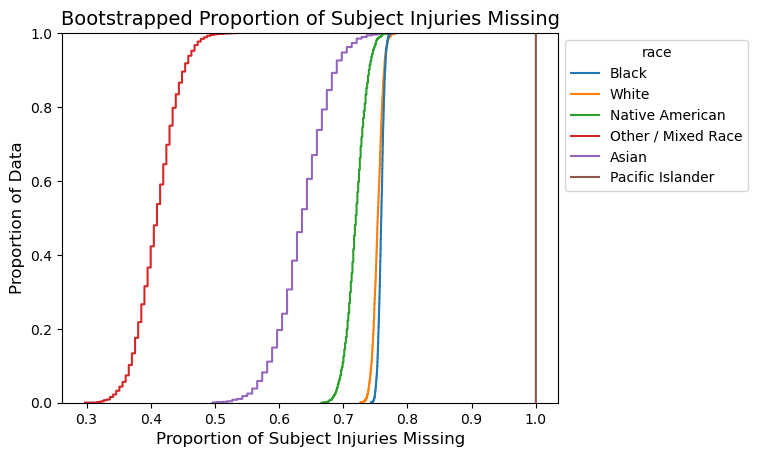

In [63]:
ax = sns.ecdfplot(data=bootstrap_df, x="proportion", hue="race")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("Bootstrapped Proportion of Subject Injuries Missing", fontsize=14)
ax.set_xlabel("Proportion of Subject Injuries Missing", fontsize=12)
ax.set_ylabel("Proportion of Data", fontsize=12)

This plot shows there is widely varying distributions of missing values for each race. For example, "Pacific Islander" has 100% missing subject injury data. So, the ECDF (no matter what how many times you boot strap it) shows a single value of 1.0, resulting in a vertical line.

/tmp/ipykernel_19293/1646729978.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(data=bootstrap_df, x="proportion", hue="race")


Text(0.5, 1.0, 'Bootstrapped KDE of Proportion of Subject Injuries Missing')

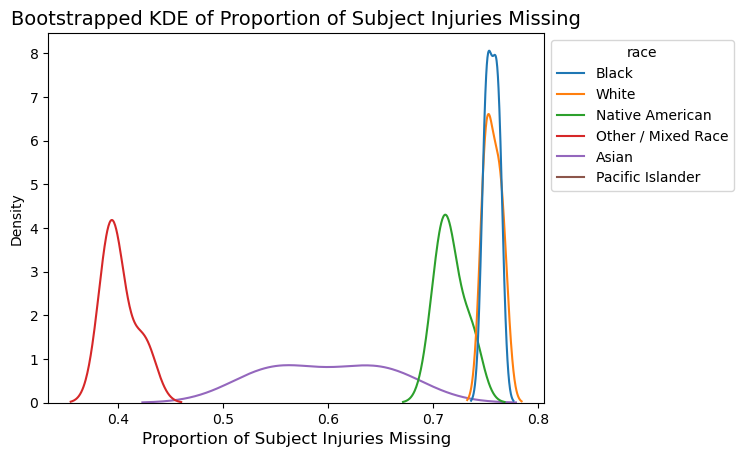

In [47]:
ax = sns.kdeplot(data=bootstrap_df, x="proportion", hue="race")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("Proportion of Subject Injuries Missing", fontsize=12)
ax.set_title("Bootstrapped KDE of Proportion of Subject Injuries Missing", fontsize=14)

The graph above shows us the relative densities computed with a kernel. You can see that the distribution of densities above is quite extreme, given that "Other / Mised Race" has a wide distribution of proportions, and "Pacific Islander" (which isnt shown above, as there is only 1 value in the series, so SNS will not graph it) has a distribution of zero.

When we consider second order uncertainty, there will be a big difference between races. Our certainty that the bootstrapping estimates are representative for "Other / Mixed Race" will be much lower than our certainty the bootstrapping estimates are representative for "Black", as the distribution for missing values for "Black" is much lower.

### Exercise 2: Invitation to Inference
- Run the simulation code line by line and comment what each line is doing, or write your own code to do the resampling
- Open the NHANES or Ames prices or College Completion data. Pick a variable and a statistic to compute (e.g. mean, median, variance, IQR)
- Use the `simulate` function from class to get a sample of estimates for your statistic and your data
- Create a new function, `interval(L,H,estimates)`, that computes the $L$-th and $H$-th quantiles for your estimates, $H>L$
- If $L=.05$ and $H=.95$, this is a **90-percent confidence interval**: "For our statistic, this interval captures the true value of the population parameter 90 percent of the time. (We are 90% **confident** that it includes the true value of the parameter, but the probability that the true parameter lies in this interval is 0 or 1.)"
- We will spend much more time on this later in class, but for people who have done hypothesis testing before, you now know how to do it directly from the data: No central limit theorem required.

### Exercise 3: Intro to A/B Testing
- Go here, and read about this study: https://www.clinicaltrials.gov/study/NCT01985360
- Read the Study Overview and explain what the goal of the trial is 
- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 
- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.
- What is the difference in surival rates between the invasive strategy and the conservative strategy?
- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF
- Is this an effective health intervention? Explain your answer clearly

This would be what CS people call **A/B testing** and everyone else called a **randomized controlled trial**: Using randomized assignment to detect the difference in outcomes between two groups. (We've just done a non-parametric version of a two-sample t-test.)

### Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$
- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.
- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$, and make KDE plots of your results.
- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?